In [4]:
import pandas as pd
import numpy as np



# from scipy.stats import spearmanr, rankdata
# from scipy.spatial.distance import pdist, squareform
import random
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import KFold

In [5]:
def load_data(path):

    files = os.listdir(f'{path}\\img\\data\\')
    image = np.empty((len(files), 50, 50, 1))
    sample = []
    id = []
    for i in range(len(files)):
        if files[i].split('.')[1] == 'txt':
            id.append(i)
            data = pd.read_csv(f'{path}\\img\\data\\{files[i]}', sep='\t', engine='c', na_values=['na', '-', ''], header=None, index_col=None)
            image[i, :, :, 0] = data.values
            sample.append(files[i].split('.txt')[0])
    image = image[id, :, :, :]

    return image

In [6]:
def top_n_miRNA(input_data, n):
    temp_df = input_data.copy()
    temp_df['sums'] = (temp_df.iloc[:,1:].sum(axis = 1))
    temp_df = temp_df.sort_values(by='sums', ascending=False)
    return temp_df.iloc[0:n,0:-1]


In [48]:
def zero_balance_data(x_tn, y_lb):
    if(x_tn.shape[0]==y_lb.shape[0]):
        nonzero_index_r = y_lb.index[y_lb['amount']>0].to_list() #list of zero indices
        zero_index = y_lb.index[y_lb['amount']==0].to_list() #list of zero indices

        if (len(nonzero_index_r)<len(zero_index)):
            zero_index_r = random.choices(zero_index, k=len(nonzero_index_r))
            final_ind = nonzero_index_r + zero_index_r

            x_tn_temp = x_tn[final_ind,:,:,:]
            y_lb_temp = y_lb.loc[final_ind]
            return x_tn_temp, y_lb_temp 
        else:
            return x_tn, y_lb 

    else:
        print('Dataset Shape did not match!!')

In [8]:
# def train_test_data(data_main, test_per = 0.2):
#     rand_test_index= np.random.randint(0, data_main.shape[0], np.int64(data_main.shape[0]*test_per))
#     test_data = data_main[rand_test_index]
#     train_data = np.delete(data_main, rand_test_index, axis = 0)

#     return train_data, test_data, rand_test_index


# train_data, test_data, test_indx = train_test_data(all_data, test_per=0.1)

In [9]:
# xx = [1,2,3,4,5]
# yy = [9,8,7,6,5]

# xx = np.array(xx)
# yy = np.array(yy)


# indx = [1,2]
# indy = [0,4]

# iii = indx+indy

# print(xx[iii])
# print(yy[iii])


In [59]:
# data_path = '..\\Results\\Table_To_Image_Conversion\\Test_1\\data'
data_path = "D:\\Research\\data\\processed_dataset" #lab

# tissue_type = 'liver'
tissue_type = 'pancreas'
# tissue_type = 'kidney'
# tissue_type = 'heart'
# tissue_type = 'brain_myeloid'
# tissue_type = 'marrow'


In [60]:
all_data = load_data(path = f'{data_path}\\{tissue_type}')
all_data.shape

(1961, 50, 50, 1)

In [61]:
all_data = all_data/255

In [62]:
y_target = pd.read_csv(f'{data_path}\\{tissue_type}\\miRNA_bulk.csv')
y_target = y_target.drop('Unnamed: 0',axis=1)

# y_target = y_target.iloc[:,1:].drop(y_target.index[(y_target.iloc[:,1:].sum(axis = 1) < 1000)]).T


y_target.shape

# y_target = y_target.iloc[:,1:].T
# y_target = y_target.values
# y_target

# y_target['sums'] = (y_target.iloc[:,1:].sum(axis = 1))
# y_target.sort_values(by='sums', ascending=False)
# y_target.iloc[0:50,0:-1]


(282, 1962)

In [63]:
top_miRNAs = top_n_miRNA(y_target, 1)

top_miRNAs = top_miRNAs.iloc[:,1:].T
top_miRNAs = top_miRNAs.rename(columns={top_miRNAs.columns[0]: "amount"})
sIdex = [i for i in range(top_miRNAs.shape[0])]
top_miRNAs = top_miRNAs.set_index([sIdex])
top_miRNAs


,amount
0,0
1,0
2,0
3,0
4,0
...,...
1956,0
1957,0
1958,0
1959,0


In [64]:
all_data, top_miRNAs = zero_balance_data(all_data,top_miRNAs)


In [65]:
nonzero_index_r = top_miRNAs.index[top_miRNAs['amount']>0].to_list() #list of zero indices
zero_index = top_miRNAs.index[top_miRNAs['amount']==0].to_list() #list of zero indices
# zero_index_r = random.choices(zero_index, k=len(nonzero_index_r))
# final_ind = nonzero_index_r + zero_index_r

# x_tn_temp = all_data[final_ind,:,:,:]
# y_lb_temp = top_miRNAs.loc[final_ind]

In [66]:
len(zero_index)

251

In [69]:
top_miRNAs.shape

(502, 1)

In [44]:
# total_sample = top_miRNAs.shape[0]
# ex_lvl = [0 for l in range(total_sample)]
# top_miRNAs['ex_lvl'] = ex_lvl
# top_miRNAs = top_miRNAs.reset_index()
# top_miRNAs


,index,amount,ex_lvl
0,0,2,0
1,1,9,0
2,2,8,0
3,4,18,0
4,5,22,0
...,...,...,...
9023,2325,0,0
9024,4043,0,0
9025,577,0,0
9026,648,0,0


In [45]:
for i in range(total_sample):
    if(top_miRNAs['amount'][i]<10):
        top_miRNAs['ex_lvl'][i] = 0
    elif(top_miRNAs['amount'][i]<100):
        top_miRNAs['ex_lvl'][i] = 1
    else:
        top_miRNAs['ex_lvl'][i] = 2


# for i in range(total_sample):
#     if(top_miRNAs['amount'][i]<10):
#         top_miRNAs['ex_lvl'][i] = 0
#     else:
#         top_miRNAs['ex_lvl'][i] = 1


In [46]:
top_miRNAs_lbl = top_miRNAs.ex_lvl.values
encoded_array = np.zeros((top_miRNAs_lbl.size, top_miRNAs_lbl.max()+1), dtype=int)
encoded_array[np.arange(top_miRNAs_lbl.size),top_miRNAs_lbl] = 1 
top_miRNAs_lbl = encoded_array

In [47]:
top_miRNAs_lbl.shape


(9028, 3)

In [48]:
top_miRNAs_lbl

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [49]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# scaled = scaler.fit_transform(top_miRNAs.iloc[:,1:])

# top_miRNAs = preprocessing.MinMaxScaler(top_miRNAs.iloc[:,1:].T)
# top_miRNAs
# top_miRNAs = top_miRNAs.iloc[:,1:].values.T

In [50]:
# top_miRNAs = top_miRNAs.T
# bins = [0, 99, 199, 299, 399, 499, 599, 699, 799, 899, 999]
# labels = ['J', 'I', 'H', 'G', 'F', 'E', 'D','C', 'B', 'A',]

def show_grade(smple):
    bins = [0, 1, 19, 29, 39, 49, 59, 69, 79, 89, 99, 999]
    labels = ['K','J', 'I', 'H', 'G', 'F', 'E', 'D','C', 'B', 'A',]
    smple['grade'] = pd.cut(x = smple['amount'], bins = bins, labels = labels, include_lowest = True)

In [51]:
# show_grade(top_miRNAs)

In [52]:
# top_miRNAs.sort_values(by='amount')


In [53]:
# top_miRNAs['grade'].value_counts()


In [54]:
# quantiles  = top_miRNAs['grade'].value_counts().quantile([0.25, 0.5, 0.75])
# quantiles.plot(marker='o')
# plt.xlabel('Quantile')
# plt.ylabel('Value')
# plt.title('Quantiles')
# plt.show()

In [55]:
# X_train, X_test, y_train, y_test = train_test_split(all_data, y_target, test_size=0.1, random_state=5)

# print(f'X_train: {X_train.shape}')
# print(f'X_test: {X_test.shape}')
# print(f'y_train: {y_train.shape}')
# print(f'y_test: {y_test.shape}')



In [56]:
# for train_indices, test_indices in kfold.split(all_data):
#     y_train, y_val = top_miRNAs.values[train_indices], top_miRNAs.values[test_indices]


In [57]:
top_miRNAs_lbl


array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [58]:

# def runCNN(train_x_input, train_y_input, val_x, val_y, epoch_num = 10, batch_num = 32):
# # Define the model
#     model = keras.Sequential()

#     # Add the layers to the model
#     model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])))
#     model.add(keras.layers.BatchNormalization())
#     model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
#     model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
#     model.add(keras.layers.BatchNormalization())
#     model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
#     model.add(keras.layers.Conv2D(16, (3, 3), activation='relu'))
#     model.add(keras.layers.BatchNormalization())

#     # Flatten the output before passing it to the fully connected layers
#     model.add(keras.layers.Flatten())

#     # Add fully connected layers
#     model.add(keras.layers.Dense(128, activation='relu'))
#     model.add(keras.layers.Dense(64, activation='relu'))
#     model.add(keras.layers.Dense(train_y_input.shape[1], activation='softmax'))

#     # Compile the model
#     model.compile(optimizer='Adam',
#                 loss='mse',
#                 metrics=['accuracy'])

#     # Print the model summary
#     print(model.summary())

#     history = model.fit(train_x_input, train_y_input, epochs=epoch_num, batch_size=batch_num, validation_data = (val_x, val_y))

#     return model, history


In [59]:
def plot_history(his, tissue_type = ''):
    plt.plot(his.history['accuracy'])
    plt.plot(his.history['val_accuracy'])
    plt.title(f'Model Accuracy: {tissue_type}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    plt.plot(his.history['loss'])
    plt.plot(his.history['val_loss'])
    plt.title(f'Model Loss: {tissue_type}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


In [60]:
model = keras.Sequential()

# Add the layers to the model
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(all_data.shape[1], all_data.shape[2], all_data.shape[3])))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(16, (3, 3), activation='relu'))
model.add(keras.layers.BatchNormalization())


# Flatten the output before passing it to the fully connected layers
model.add(keras.layers.Flatten())

# Add fully connected layers
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(top_miRNAs_lbl.shape[1], activation='softmax'))

# Define a custom learning rate
learning_rate = 0.0001
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

# BinaryCrossentropy
# CategoricalCrossentropy
# Compile the model
model.compile(optimizer='Adam',
            loss='BinaryCrossentropy',
            metrics=['accuracy'])

# Print the model summary
print(model.summary())




Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_3 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 22, 22, 32)        18464     
                                                                 
 batch_normalization_4 (Batc  (None, 22, 22, 32)       128       
 hNormalization)                                                 
                                                      

In [61]:
# model_pan, history_pan = runCNN(train_x_input=X_train, train_y_input=y_train, epoch_num=100, val_x=X_test,  val_y=y_test)

In [62]:
# plot_history(history_pan, tissue_type=tissue_type)

In [63]:
num_folds = 5
fold_scores = []
epoch_num = 50
batch_num = 32

kfold = KFold(n_splits=num_folds, shuffle=True)

# y_label = top_miRNAs.amount.values
train_acc_values = []
val_acc_values = []

for train_indices, test_indices in kfold.split(all_data):
    # print('Train: %s | test: %s' % (train_indices, test_indices))


    X_train, X_val = all_data[train_indices], all_data[test_indices]
    y_train, y_val = top_miRNAs_lbl[train_indices], top_miRNAs_lbl[test_indices]

    history = model.fit(X_train, y_train, epochs=epoch_num, batch_size=batch_num, validation_data = (X_val, y_val))

    _, score = model.evaluate(X_val, y_val)
    fold_scores.append(score)

    train_acc_values.append(history.history['accuracy'])
    val_acc_values.append(history.history['val_accuracy'])


Epoch 1/50
226/226 [==============================] - 8s 34ms/step - loss: 0.3414 - accuracy: 0.7917 - val_loss: 0.3926 - val_accuracy: 0.7968
Epoch 2/50
226/226 [==============================] - 8s 35ms/step - loss: 0.3049 - accuracy: 0.8079 - val_loss: 0.3383 - val_accuracy: 0.7968
Epoch 3/50
226/226 [==============================] - 29s 128ms/step - loss: 0.2632 - accuracy: 0.8334 - val_loss: 0.3335 - val_accuracy: 0.8001
Epoch 4/50
226/226 [==============================] - 10s 44ms/step - loss: 0.2191 - accuracy: 0.8564 - val_loss: 0.4345 - val_accuracy: 0.6894
Epoch 5/50
226/226 [==============================] - 8s 37ms/step - loss: 0.1579 - accuracy: 0.9039 - val_loss: 0.7360 - val_accuracy: 0.3516
Epoch 6/50
226/226 [==============================] - 8s 33ms/step - loss: 0.1165 - accuracy: 0.9288 - val_loss: 1.6062 - val_accuracy: 0.2896
Epoch 7/50
226/226 [==============================] - 8s 37ms/step - loss: 0.0821 - accuracy: 0.9517 - val_loss: 2.3242 - val_accuracy: 0.2

In [64]:
np.mean(fold_scores)

0.7848158240318298

In [65]:
# train_acc_values_t = train_acc_values[0]+train_acc_values[1]+train_acc_values[2]+train_acc_values[3]+train_acc_values[4]
# val_acc_values_t = val_acc_values[0]+val_acc_values[1]+val_acc_values[2]+val_acc_values[3]+val_acc_values[4]
train_acc_values_t = []
val_acc_values_t = []
for i in range(num_folds):
    train_acc_values_t = train_acc_values_t + train_acc_values[i]
    val_acc_values_t = val_acc_values_t + val_acc_values[i]



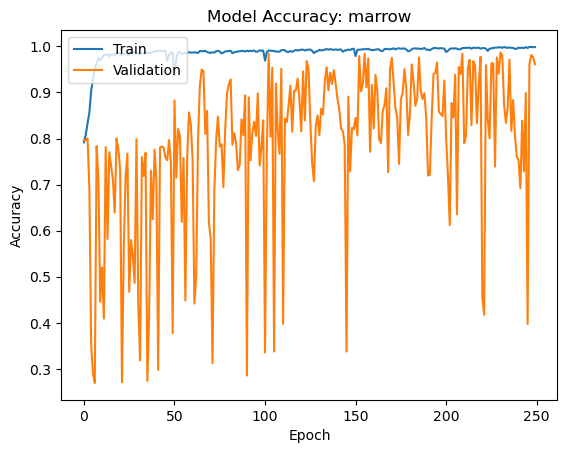

In [66]:
fig_data_path = "D:\\Research\\data\\processed_dataset_analysis\\figures" #lab

plt.plot(train_acc_values_t)
plt.plot(val_acc_values_t)
plt.title(f'Model Accuracy: {tissue_type}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig(f'{fig_data_path}\\{tissue_type}_{top_miRNAs_lbl.shape[1]}_class.png')
plt.show()






In [67]:
# pancreas 0.6637227654457092 ---------- 0.6916831731796265
# heart 0.7482193589210511 ----------- 0.5919865846633912
# brain 0.6936936855316163 ---------- 0.7126126170158387
# marrow 0.6864864885807037 ---------- 0.5675675630569458

In [68]:
top_miRNAs_lbl.shape[1]

3